In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
import hdbscan

import time
from sklearn.cluster import KMeans

In [2]:
#!source /Users/lui/Documents/3_semestr/Project/env_project/env_project_dap/bin/activate

## Identifying clusters in the 100 pc sphere

<span style="font-size:18px;">

* Clustering in the 100 pc sphere is a challenging task.
* The data is un-evenly dense in two respective subspaces. Especially the velocity space is subject to strong non-linear projection effects.
* An originally compact Gaussian point cloud can result in a highly non-convex shape in the velocity space.

Let's see what this might look like in practice.

</span>

In [3]:
# Plotting related stuff
alphas = [0.9, 0.9, 0.3]
colors = ['tab:red', 'tab:blue', 'tab:grey']
zorders = [1, 1, 0]
log = True

In [4]:
# Create 6D Gaussian data
n = 1000 #1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50

mu = np.array([-5, 5, 5, 5, -5, 5])
c_xx = c_yy = 20
c_xy = 15
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2)

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2], axis=0)
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_bg = np.where(labels==0)[0]

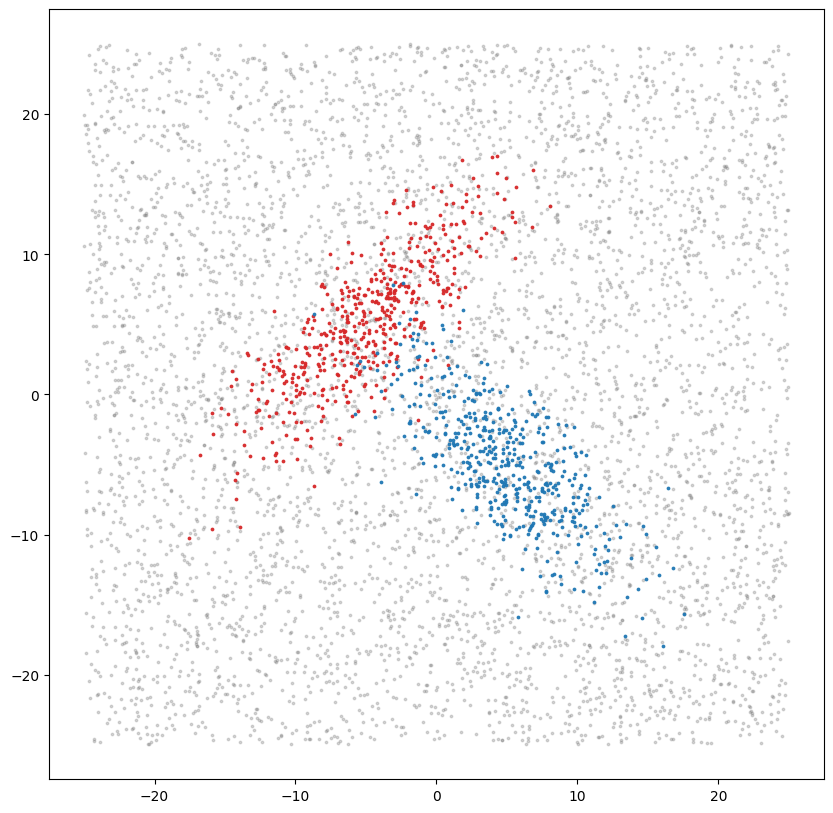

In [5]:
x_col, y_col = 'x', 'y'
# x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
# x_col, y_col = 'pmra', 'pmdec'

fig = plt.figure(figsize=(10, 10))
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_bg], alphas, colors, zorders):
    # if c == 'tab:blue':
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
# plt.xlim(-1000, 1000)
# plt.ylim(-1000, 1000)

# Optimal radial velocity class
VrOpt computes pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars.

In [6]:
est = VrOpt(ra, dec, pmra, pmdec, dist)

# Now built the distance matrix for clustering ourselves

In [7]:
# # Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

## Compute the semi-cohesion metric

<span style="font-size:18px;">

Given a semi-metric d(·,·) for $\Omega$, we define the induced semi-cohesion measure as follows:

$$ g(x, y) = \frac{1}{n} \sum_{z_2 \in \Omega} d(z_2, y) + \frac{1}{n} \sum_{z_1 \in \Omega} d(x, z_1) - \frac{1}{n^2}  \sum_{z_2 \in \Omega} \sum_{z_1 \in \Omega} d(z_2, z_1) - d(x, y) $$ 

</span>


In [8]:
# Compute semi-cohesion metric G
G = np.copy(dist_v_opt)
G = np.full_like(G, np.sum(G, axis=0)/len(G)) + np.full_like(G, np.sum(G, axis=0)/len(G)).T - np.sum(G)/len(G)**2 - G

In [9]:
# Plotting clusters depending on x_col and y_col
def plot_clusters(df, cluster_labels, true_labels, K, x_col, y_col):
    fig, ax = plt.subplots(1, K, figsize=(5*K, 5))
    for l_i in np.unique(cluster_labels):
        if l_i != -1:
            idx_sel = cluster_labels == l_i
            ax[l_i].scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s = 3, alpha = 0.8, zorder = 1, c = true_labels[idx_sel])
            ax[l_i].set_xlabel(x_col)
            ax[l_i].set_ylabel(y_col)
    plt.tight_layout()
    plt.show()

## Implement the K-sets+ algorithm

from this paper https://arxiv.org/pdf/1705.04249

In [10]:
def ksets_plus_optimized(G, K, max_iter=100, method="random"):

    start_time = time.time()
    n = G.shape[0]
    np.random.seed(42)

    # Initialize K disjoint sets
    if method == "random":
        sets = np.random.randint(0, K, size=n)
    elif method == "kmeans":
        kmeans = KMeans(n_clusters=K, random_state=42)
        sets = kmeans.fit_predict(df[['x', 'y', 'z']].values)
    else:
        raise ValueError("Invalid method")
        

    for iteration in range(max_iter):
        
        changes = 0 # Track changes

        
        G_diag = np.diag(G) # Precompute diagonal of G, G[x,x]

        # Compute current cluster sizes |S| - necessary for computing adjusted distances
        cluster_sizes = np.array([np.sum(sets == k) for k in range(K)])

        # Binary matrix to track whether point belongs to specific set
        membership_matrix = np.zeros((n, K))
        for k in range(K):
            membership_matrix[:, k] = (sets == k).astype(int)

        # Compute G[S, S] 
        set_sums = membership_matrix.T @ G @ membership_matrix

        # Compute G[x, S] 
        point_set_sums = G @ membership_matrix

   
        distances = np.zeros((n, K))
        for k in range(K):

            s_size = cluster_sizes[k]

            if s_size == 0:
                continue

            outside_sets = (sets != k)
            inside_sets = (sets == k)

            # For points outside set
            distances[outside_sets, k] = ((s_size / (s_size + 1)) * (G_diag[outside_sets] - 2 * point_set_sums[outside_sets, k] / s_size + set_sums[k, k] / (s_size ** 2)))

            # For points inside set
            if s_size > 1:
                distances[inside_sets, k] = ((s_size / (s_size - 1)) * (G_diag[inside_sets] - 2 * point_set_sums[inside_sets, k] / s_size + set_sums[k, k] / (s_size ** 2)))
            else:
                distances[inside_sets, k] = -np.inf  

        # Assign points to set with minimum distance
        best_clusters = np.argmin(distances, axis=1)

        # Number of changes
        changes = np.sum(sets != best_clusters)

        sets = best_clusters

        # If no further changes => stop
        if changes == 0:
            break

    execution_time = time.time() - start_time
    print(f'Execution time: {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations: {iteration + 1}')

    return sets


## Implement the Softmax Clustering Algorithm

from this paper https://arxiv.org/abs/1708.00316

In [11]:
# get clusters from probability
def get_clusters(p_i):

    cluster_labels = np.argmax(p_i, axis=1)
    _, relabeled_clusters = np.unique(cluster_labels, return_inverse=True)
    
    return relabeled_clusters


In [12]:
def softmax_clustering_optimized_iphd(Gamma, K, theta=0.001, epsilon=0.0001, max_iter=250, initial_partition=None):

    start_time = time.time()

    # Set g[i,i] = 0 for all i
    np.fill_diagonal(Gamma, 0)
    n = Gamma.shape[0]

    np.random.seed(42)

    # Use the initial partition if provided, otherwise initialize randomly
    if initial_partition is not None:
        p_i = initial_partition
    else:
        p_i = np.random.dirichlet(np.ones(K), size=n)

    z = np.zeros((n, K))  # for covariance

    for iteration in range(max_iter):
        # Compute covaraince (z)for all points and clusters
        
        z = Gamma @ p_i 
        # Stabilize softmax computation
        z_max = np.max(theta * z, axis=1, keepdims=True) 
        p_t = np.exp(theta * z - z_max) * p_i  

        #p_t = np.exp(theta * z) * p_i  # Softmax function
        p_i = p_t / (np.sum(p_t, axis=1, keepdims=True) + 1e-10)  # Update probability uisng softmax function and normalize it (it must sum to 1)

        theta += epsilon

         # If pi changes insignificantly, stop
        if iteration > 0 and np.allclose(p_i, prev_pi, atol=1e-6):
            break

        prev_pi = p_i.copy()
        
    execution_time = time.time() - start_time
    print(f'Execution time (softmax): {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations (softmax): {iteration + 1}')

    return p_i, z

In [13]:
K = 6
p_i_opt, z_opt = softmax_clustering_optimized_iphd(G, K)

#print("Probability partition of data points (pi):")
#print(p_i_opt)
#print("Embedding of data points(z):")
#print(z_opt)


Execution time (softmax): 0 minutes, 2 seconds and 745 ms
Number of iterations (softmax): 143


In [14]:
# get cluster labels and number of clusters
labels_softmax_opt= get_clusters(p_i_opt) 
unique_clusters = np.unique(labels_softmax_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

3


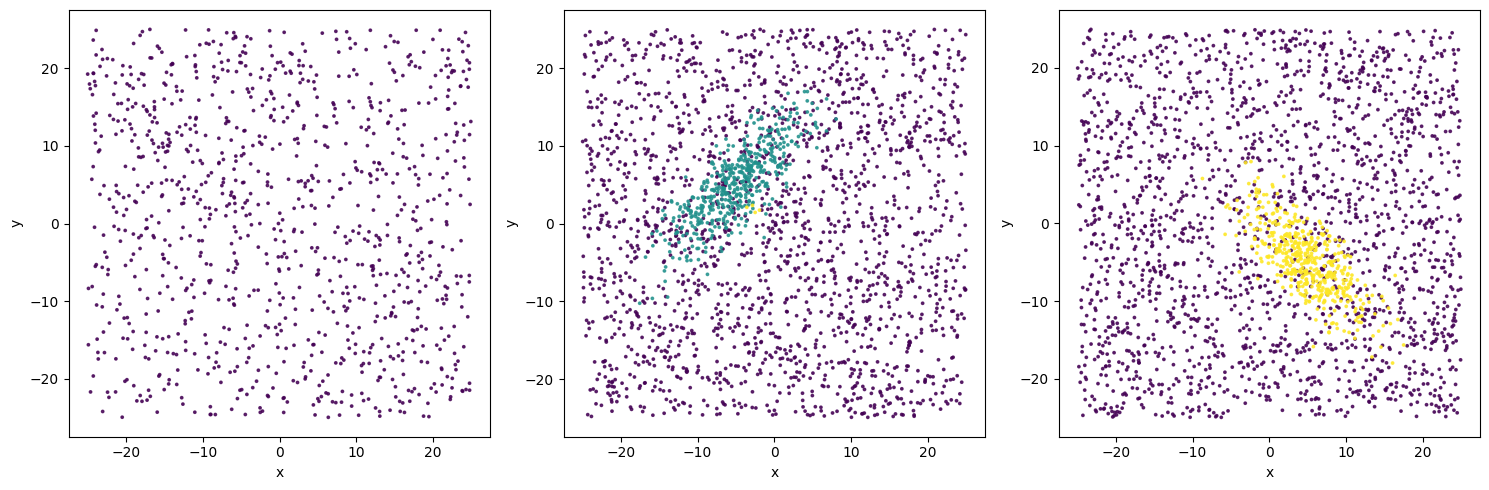

In [15]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_softmax_opt, labels, num_clusters, x_col, y_col)

# Clustering with KD tree, Softmax algorithm, and Hierarchical agglomerative algorithm

In [16]:
# Safe true labels from dataset
original_label = labels

In [17]:
from scipy.spatial import KDTree
from scipy.sparse import lil_matrix

class TreeNode:
  
    def __init__(self, kd_node, point_indices):
        self.kd_node = kd_node
        self.point_indices = point_indices
        self.left = None
        self.right = None
        self.cluster = set(point_indices)

# Traverse kdtree and extract only its leaf nodes
def extract_leaf_nodes(kd_node, point_indices, points, node_indices, point_in_node):
  
    if isinstance(kd_node, KDTree.leafnode):
        unique_indices = np.setdiff1d(point_indices, list(point_in_node.keys()), assume_unique=True)
        if len(unique_indices) > 0:
            node_indices.append(unique_indices)
            point_in_node.update({idx: len(node_indices) - 1 for idx in unique_indices})
    else:
        split_dim = kd_node.split_dim
        split_val = kd_node.split
        left_indices = point_indices[points[point_indices, split_dim] <= split_val]
        right_indices = point_indices[points[point_indices, split_dim] > split_val]

        extract_leaf_nodes(kd_node.less, left_indices, points, node_indices, point_in_node)
        extract_leaf_nodes(kd_node.greater, right_indices, points, node_indices, point_in_node)

# Compute semi-cohesion G matrix
def compute_g_matrix(dist_matrix):

    G = np.full_like(dist_matrix, np.sum(dist_matrix, axis=0)/len(dist_matrix)) + np.full_like(dist_matrix, np.sum(dist_matrix, axis=0)/len(dist_matrix)).T - np.sum(dist_matrix)/len(dist_matrix)**2 - dist_matrix
    return G

# Run softmax clustering for each leaf node
def softmax_clustering_leaves(node_indices, G, K, softmax_clustering_func):
  
    cluster_results = []
    for i, indices in enumerate(node_indices):
        subset_G = G[np.ix_(indices, indices)]
        p_i, z = softmax_clustering_func(subset_G, K)
        cluster_labels_node = get_clusters(p_i)

        # Just for testing
        num_clusters = len(np.unique(cluster_labels_node))
        print(f"Leaf Node {i + 1}:")
        print(f" - Number of clusters: {num_clusters}")
        print(f" - Number of points: {len(indices)}")

        cluster_results.append((cluster_labels_node, indices))
    return cluster_results

# Correlation measure q for merging clusters
def compute_q(S1, S2, G):
   
    return np.sum(G[np.ix_(list(S1), list(S2))])

def hierarchical_agglomerative_merging(clusters, G):
   
    cluster_count = len(clusters)
    q_matrix = lil_matrix((cluster_count, cluster_count), dtype=np.float64)

    # q-matrix
    for i, cluster1 in enumerate(clusters):
        for j, cluster2 in enumerate(clusters[i + 1:], start=i + 1):
            q_matrix[i, j] = compute_q(cluster1, cluster2, G)

    while len(clusters) > 1:
        # Convert to CSR for efficient matrix operations
        q_csr = q_matrix.tocsr()
        max_index = q_csr.argmax()
        i, j = divmod(max_index, q_matrix.shape[1])

        if q_matrix[i, j] <= 0:
            print("No positive q values, stopping merging.")
            break

        print(f"Merging cluster {i} with cluster {j}, q = {q_matrix[i, j]}")

        # Merge clusters
        clusters[i] = clusters[i].union(clusters[j])
        clusters[j] = set()

        # Update q-matrix for merged cluster
        for k, cluster in enumerate(clusters):
            if cluster and k != i and k != j:
                q_matrix[i, k] = compute_q(clusters[i], cluster, G)
                q_matrix[k, i] = q_matrix[i, k]

        # Deactivate merged clusters
        q_matrix[j, :] = 0
        q_matrix[:, j] = 0

    return [cluster for cluster in clusters if cluster]


def tree_merging_clustering(df, dist_matrix, K, node_indices, point_in_node, softmax_clustering_func = softmax_clustering_optimized_iphd):
   
    print(f"Total number of points assigned to leaf nodes: {len(point_in_node)}")
    # G matrix
    G = compute_g_matrix(dist_matrix)

    # Softmax clustering for each leaf node
    cluster_results_softmax = softmax_clustering_leaves(node_indices, G, K, softmax_clustering_func)
    print(cluster_results_softmax)

    # Get initial clusters for merging
    clusters = [
        {idx for idx, lbl in zip(indices, labels) if lbl == label}
        for labels, indices in cluster_results_softmax
        for label in np.unique(labels)
    ]

    # Hierarchical agglomerative merging
    final_clusters = hierarchical_agglomerative_merging(clusters, G)

    total_points_final = len(set().union(*final_clusters))
    print(f"Original number of points: {len(df)}")
    print(f"Total unique points in final clusters: {total_points_final}")

    return cluster_results_softmax, final_clusters


def prepare_kdtree(df, leafsize=300):
    points = df[['x', 'y', 'z']].values
    kd_tree = KDTree(points, leafsize=leafsize)

    node_indices = []
    point_in_node = {}
    extract_leaf_nodes(kd_tree.tree, np.arange(len(points)), points, node_indices, point_in_node)
    return node_indices, point_in_node

In [18]:
K = 6
leaf_size = 300 

node_indices, point_in_node = prepare_kdtree(df, leafsize=300)
cluster_results_softmax, final_clusters = tree_merging_clustering(df, dist_v_opt, K, node_indices, point_in_node)

Total number of points assigned to leaf nodes: 6000
Execution time (softmax): 0 minutes, 0 seconds and 12 ms
Number of iterations (softmax): 225
Leaf Node 1:
 - Number of clusters: 4
 - Number of points: 189
Execution time (softmax): 0 minutes, 0 seconds and 13 ms
Number of iterations (softmax): 250
Leaf Node 2:
 - Number of clusters: 3
 - Number of points: 188
Execution time (softmax): 0 minutes, 0 seconds and 11 ms
Number of iterations (softmax): 221
Leaf Node 3:
 - Number of clusters: 4
 - Number of points: 188
Execution time (softmax): 0 minutes, 0 seconds and 10 ms
Number of iterations (softmax): 189
Leaf Node 4:
 - Number of clusters: 4
 - Number of points: 186
Execution time (softmax): 0 minutes, 0 seconds and 13 ms
Number of iterations (softmax): 250
Leaf Node 5:
 - Number of clusters: 4
 - Number of points: 188
Execution time (softmax): 0 minutes, 0 seconds and 11 ms
Number of iterations (softmax): 205
Leaf Node 6:
 - Number of clusters: 5
 - Number of points: 188
Execution ti

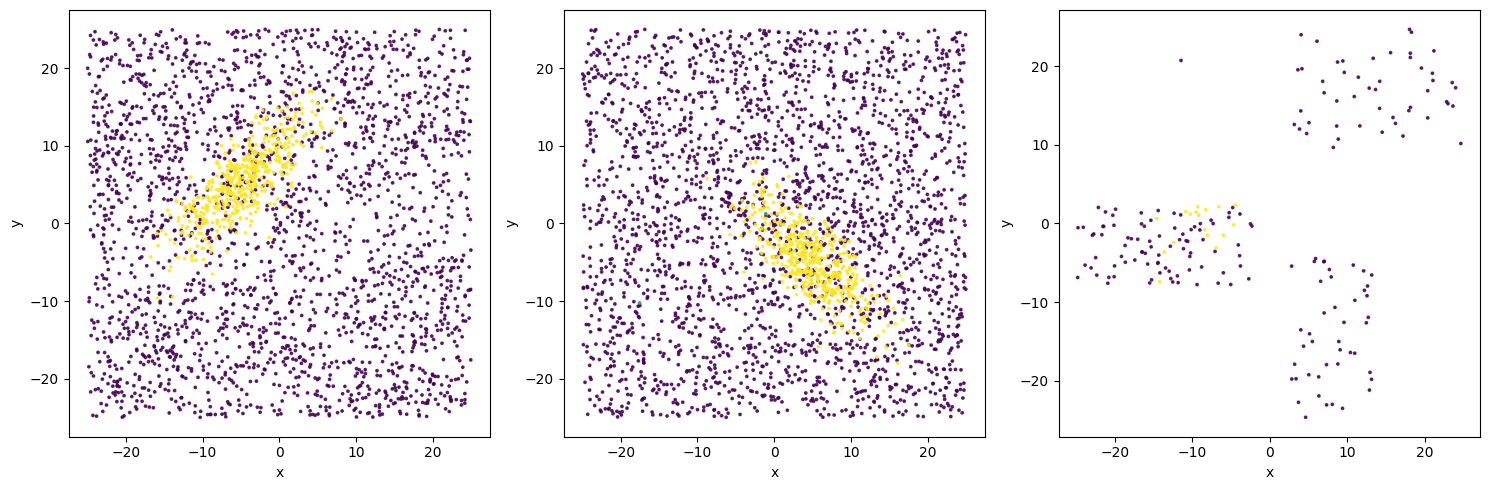

In [19]:
original_label = labels  
cluster_labels = np.zeros(len(df), dtype=int) - 1  
for i, cluster in enumerate(final_clusters):
    for index in cluster:
        cluster_labels[index] = i

x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, cluster_labels, original_label, len(final_clusters), x_col, y_col)

## Test larger dataset

In [20]:
# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

In [21]:

# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

# Create 6D Gaussian data
np.random.seed(42) 
n = 500# 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50 #background dataset of random points uniformly distributed 6D

mu = np.array([-5, 5, 5, 5, -5, 5]) #first 3 for average position of the Cluster in 3D(XYZ). Last 3 for average velocities in (VxVyVz)
c_xx = c_yy = 20 #Variance of the average in x and y.
c_xy = 15 # correlation of x and y, positive -> there is a correlation 
c_zz = 3 #Variance in z 
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy #makes positive correlation of x and y
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2) #generate n/2 data points based on mu and cov

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

# Additional clusters' parameters
# Cluster 3
mu_3 = np.array([10, -10, -10, -10, 10, -10])
c_xx_3 = c_yy_3 = 25 # More spread in X-Y plane
c_xy_3 = 10
c_zz_3 = 4
cov_3 = np.diag([c_xx_3, c_yy_3, c_zz_3, c_uvw, c_uvw, c_uvw])
cov_3[0, 1] = cov_3[1, 0] = c_xy_3
X_sig_3 = np.random.multivariate_normal(mu_3, cov_3, n//2)

# Cluster 4
mu_4 = np.array([-7, -7, -7, -7, -7, -7])
c_xx_4 = c_yy_4 = 30
c_xy_4 = -12
c_zz_4 = 5
cov_4 = np.diag([c_xx_4, c_yy_4, c_zz_4, c_uvw, c_uvw, c_uvw])
cov_4[0, 1] = cov_4[1, 0] = c_xy_4
X_sig_4 = np.random.multivariate_normal(mu_4, cov_4, n//2)

# Cluster 5
mu_5 = np.array([2, -2, -2, 2, 2, 2])
c_xx_5 = c_yy_5 = 35
c_xy_5 = 8
c_zz_5 = 6
cov_5 = np.diag([c_xx_5, c_yy_5, c_zz_5, c_uvw, c_uvw, c_uvw])
cov_5[0, 1] = cov_5[1, 0] = c_xy_5
X_sig_5 = np.random.multivariate_normal(mu_5, cov_5, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2, X_sig_3, X_sig_4, X_sig_5], axis=0) #5000 bg stars, and 5*500 cluster stars
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2, np.ones(n//2)*3, np.ones(n//2)*4, np.ones(n//2)*5])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_cluster_3 = np.where(labels==3)[0]
idx_cluster_4 = np.where(labels==4)[0]
idx_cluster_5 = np.where(labels==5)[0]
idx_bg = np.where(labels==0)[0]


# Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v



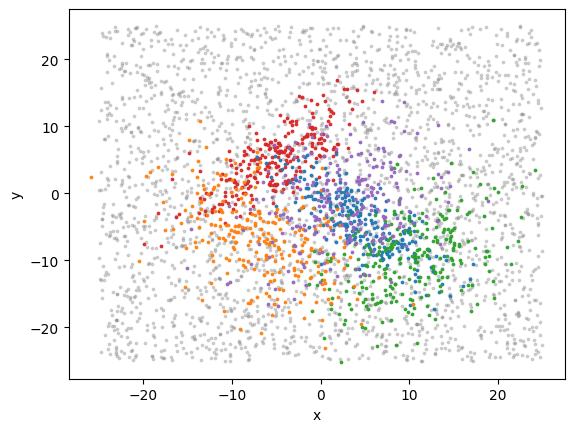

In [22]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg], alphas, colors, zorders): 
    plt.xlabel(x_col)  # Set the x-axis label
    plt.ylabel(y_col)  # Set the y-axis label
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)


In [23]:
import plotly.graph_objs as go
import matplotlib.colors as mcolors

def plot_clusters_3d(df, labels, colors):
    # colors to HEX
    color_hex = [mcolors.to_hex(mcolors.CSS4_COLORS.get(c, c)) for c in colors]

    # for background 
    data = [
        go.Scatter3d(
            x=df.loc[labels == 0, 'x'], y=df.loc[labels == 0, 'y'], z=df.loc[labels == 0, 'z'],
            mode='markers',
            marker=dict(size=2, color=color_hex[-1], opacity=0.1),
            name='Background'
        )
    ] + [
        # for clusters
        go.Scatter3d(
            x=df.loc[labels == idx, 'x'], y=df.loc[labels == idx, 'y'], z=df.loc[labels == idx, 'z'],
            mode='markers',
            marker=dict(size=3, color=color_hex[idx - 1], opacity=0.5),
            name=f'Cluster {idx}'
        ) for idx in range(1, 6)
    ]

    # layout
    fig = go.Figure(
        data=data,
        layout=go.Layout(
            margin=dict(l=0, r=0, b=0, t=0),
            scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
            legend=dict(itemsizing='constant', font=dict(size=20))
        )
    )
    fig.show()

# Usage example
plot_clusters_3d(df, labels, colors)


In [24]:
est = VrOpt(ra, dec, pmra, pmdec, dist)

In [25]:
# Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

In [26]:
# Compute semi-cohesion metric G (NxN)
G = np.copy(dist_v_opt)
G = np.full_like(G, np.sum(G, axis=0)/len(G)) + np.full_like(G, np.sum(G, axis=0)/len(G)).T - np.sum(G)/len(G)**2 - G

## Result on larger dataset after using just Softmax

In [27]:
K = 10
p_i_opt, z_opt = softmax_clustering_optimized_iphd(G, K, theta = 5, epsilon=0.01)

# get cluster labels and number of clusters
labels_softmax_opt= get_clusters(p_i_opt) 
unique_clusters = np.unique(labels_softmax_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

Execution time (softmax): 0 minutes, 0 seconds and 795 ms
Number of iterations (softmax): 40
6


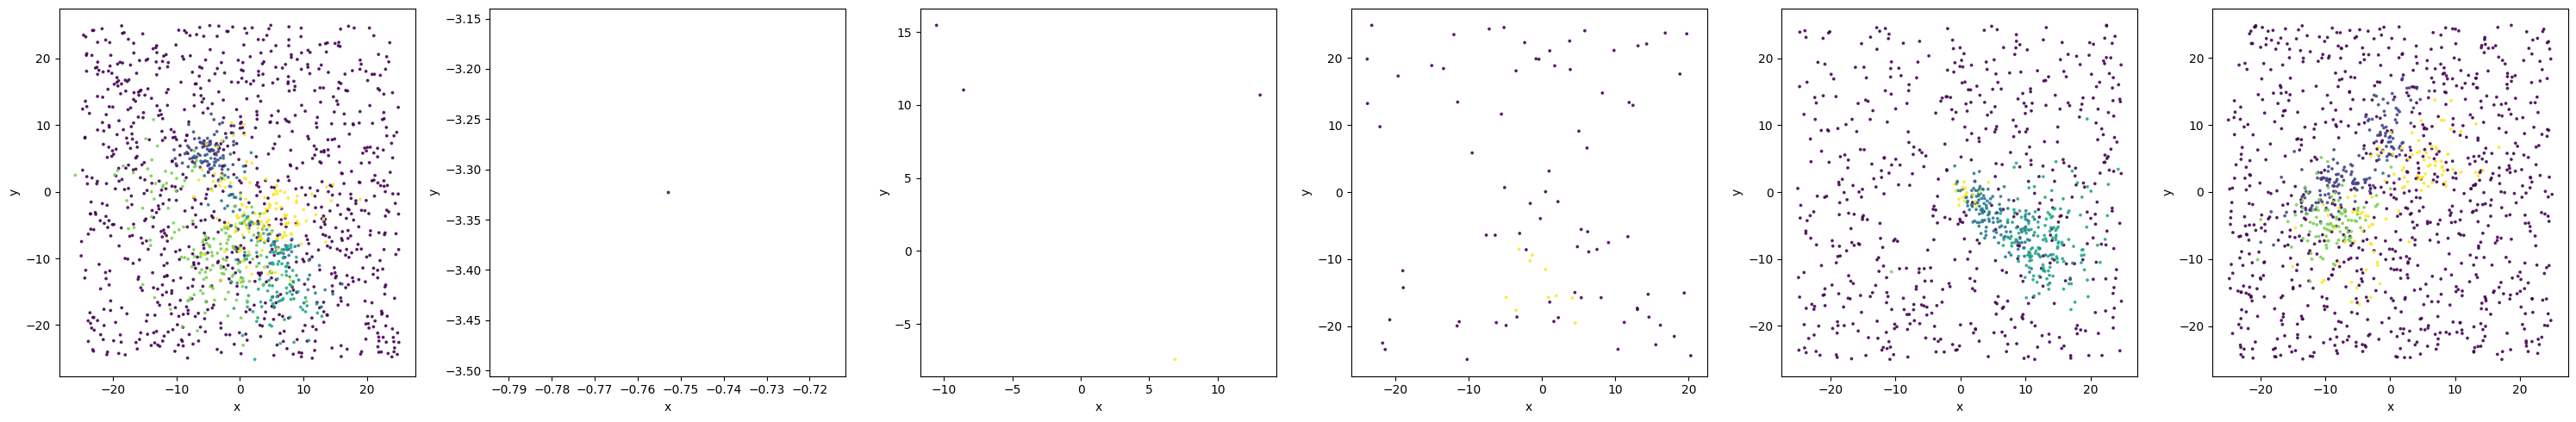

In [28]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_softmax_opt, labels, num_clusters, x_col, y_col)

## Result on larger dataset after using Kset++ and then Softmax with output from Kset++ as input

In [29]:
K = 10
initial_sets = ksets_plus_optimized(G, K, max_iter=200, method="kmeans")

n = G.shape[0]
p_i_initial = np.zeros((n, K))
for i in range(n):
    p_i_initial[i, initial_sets[i]] = 1  

theta = 0.01  
epsilon = 0.001  

p_i_opt, z_opt = softmax_clustering_optimized_iphd( G, K, theta=theta, epsilon=epsilon, initial_partition=p_i_initial)


Execution time: 0 minutes, 5 seconds and 877 ms
Number of iterations: 200
Execution time (softmax): 0 minutes, 3 seconds and 291 ms
Number of iterations (softmax): 250


In [30]:
# get cluster labels and number of clusters
labels_softmax_opt= get_clusters(p_i_opt) 
unique_clusters = np.unique(labels_softmax_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

7


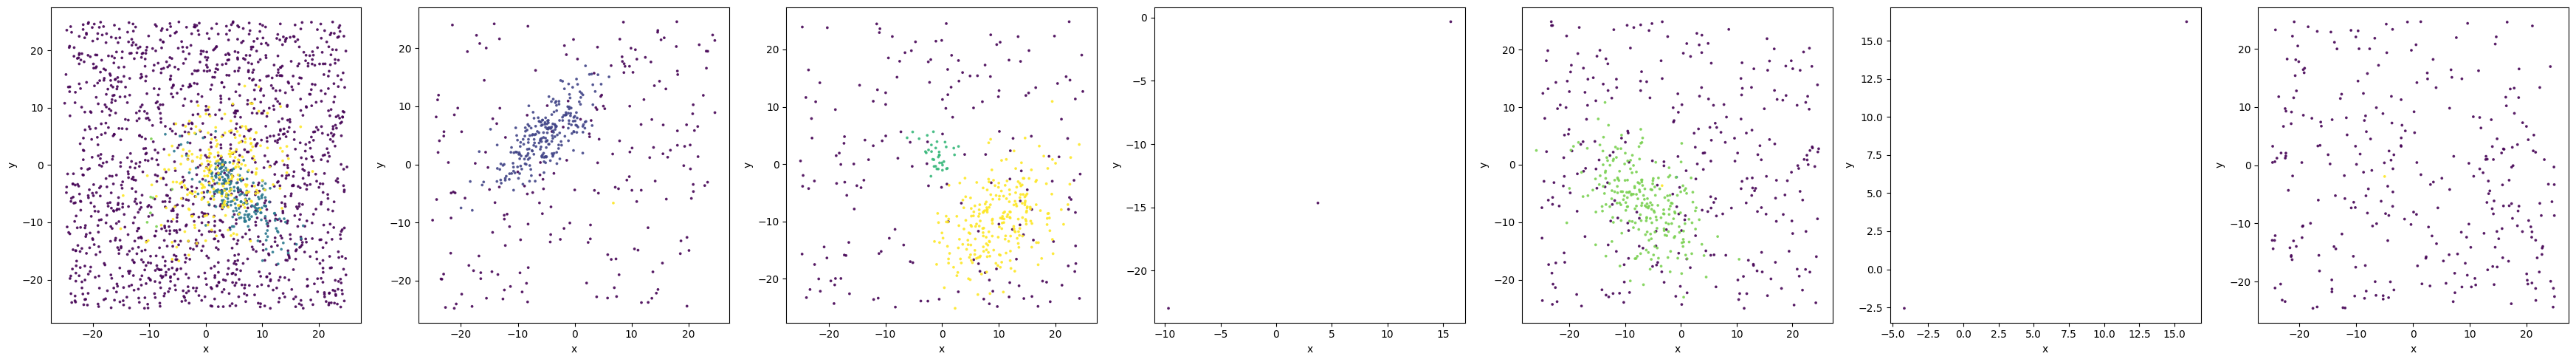

In [31]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_softmax_opt, labels, num_clusters, x_col, y_col)